In [4]:
import numpy as np, matplotlib.pyplot as plt, random
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
import pickle
from collections import Counter

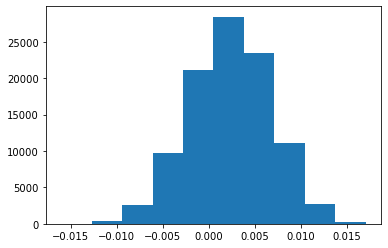

In [3]:
def init_state_circ(bits, amps):
    
    alpha = 2 * np.arccos(np.abs(amps[0]))
    s = 2 * np.arccos(np.abs(amps[1]) / np.sqrt(1 - np.abs(amps[0])**2))
    circ = Program()
    
    circ += X(bits[0])
    circ += RY(alpha, bits[1])
    circ += CNOT(bits[1], bits[0])
    
    circ += RY(s/2, bits[2])
    circ += CNOT(bits[1], bits[2])
    circ += RY(-s/2, bits[2])
    circ += CNOT(bits[1], bits[2])
    
    circ += CNOT(bits[2], bits[1])
    
    return circ

def pair_circuit(bits):
    circ = Program()
    
    circ += X(bits[0])
    circ += H(bits[1])
    circ += CNOT(bits[1],bits[0])
    
    return circ

def get_kappa(circs):
    qc = get_qc('Aspen-9', as_qvm=True)
    results = []
    
    for circ in circs:
        exe = qc.compile(circ)
        result = qc.run(exe)
        result = Counter([''.join(list(map(str,x))) for x in result])
        if '000' not in result.keys():
            result['000'] = 0
        
        results.append(result)
    
    return results

def kappa(all_counts):
    k = 3 * all_counts[0]['000']
    k += -2 * (all_counts[1]['000'] + all_counts[2]['000'] + all_counts[3]['000'])
    k += all_counts[4]['100'] + all_counts[4]['010'] + all_counts[4]['001']
    
    k = k/n_shots
    
    return k

from statistics import mean
from random import randint
def bootstrap(l, n_sample=100_000):
    sample_mean = mean(l)
    mean_l = [mean(l)]
    
    for i in range(n_sample):
        boot_sample = [l[randint(0,len(l)-1)] for j in range(len(l))]
        mean_l.append(mean(boot_sample))
    
    mean_l.sort()
    cf = (mean_l[int(0.005*len(mean_l))], mean_l[int(0.995*len(mean_l))])
    
    return (mean_l, sample_mean, cf)

bits = [10,11,12]
amps = [1/np.sqrt(3), 1/np.sqrt(3)]
circ = init_state_circ(bits, amps)

n_shots = 8192

circ_123 = circ + init_state_circ(bits, amps).dagger()
c = circ_123.declare('ro', 'BIT', 3)
for i in range(3):
    circ_123 += MEASURE(bits[i], c[i])
circ_123.wrap_in_numshots_loop(n_shots)
    
circ_12 = circ + pair_circuit([10,11]).dagger()
c = circ_12.declare('ro', 'BIT', 3)
for i in range(3):
    circ_12 += MEASURE(bits[i], c[i])
circ_12.wrap_in_numshots_loop(n_shots)
    
circ_23 = circ + pair_circuit([11, 12]).dagger()
c = circ_23.declare('ro', 'BIT', 3)
for i in range(3):
    circ_23 += MEASURE(bits[i], c[i])
circ_23.wrap_in_numshots_loop(n_shots)
    
circ_31 = circ + pair_circuit([12, 10]).dagger()
c = circ_31.declare('ro', 'BIT', 3)
for i in range(3):
    circ_31 += MEASURE(bits[i], c[i])
circ_31.wrap_in_numshots_loop(n_shots)

circ_singles = circ
c = circ_singles.declare('ro', 'BIT', 3)
for i in range(3):
    circ_singles += MEASURE(bits[i], c[i])
circ_singles.wrap_in_numshots_loop(n_shots)


circ_list = [circ_123, circ_12, circ_23, circ_31, circ_singles]

kappas = []
x = np.arange(10)
for i in x:
    all_counts = get_kappa(circ_list)
    kappas.append(kappa(all_counts))

with open('Born_2021_05_11_bits_10_11_12_8192_shots_10_runs_1_asqvm.pkl', 'wb') as file:
    pickle.dump(kappas, file)
boot_res = bootstrap(kappas)

plt.hist(boot_res[0])
plt.show()

In [2]:
boot_res[2]

(-0.0093994140625, 0.0147705078125)

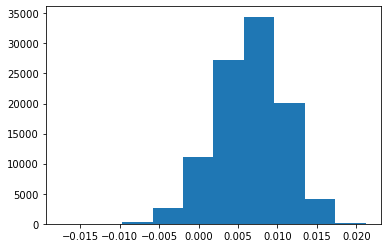

In [14]:
def init_state_circ_2(bits, amps):
    alpha = 2 * np.arccos(np.abs(amps[0]))
    s = 2 * np.arccos(np.abs(amps[1]) / np.sqrt(1 - np.abs(amps[0])**2))
    circ = Program()
    
    circ += RY(alpha, bits[0])
    circ += RY(s/2, bits[1])
    circ += CNOT(bits[0], bits[1])
    circ += RY(-s/2, bits[1])
    circ += CNOT(bits[0], bits[1])
    
    return circ

bits = [10,11]
amps = [1/np.sqrt(3), 1/np.sqrt(3)]
circ = init_state_circ_2(bits, amps)

n_shots = 8192

circ_123 = circ + init_state_circ_2(bits, [1/np.sqrt(3), 1/np.sqrt(3)]).dagger()
c = circ_123.declare('ro', 'BIT', len(bits))
for i in range(len(bits)):
    circ_123 += MEASURE(bits[i], c[i])
circ_123.wrap_in_numshots_loop(n_shots)
    

circ_12 = circ + init_state_circ_2(bits, [1/np.sqrt(2), 1/np.sqrt(2)]).dagger()
c = circ_12.declare('ro', 'BIT', len(bits))
for i in range(len(bits)):
    circ_12 += MEASURE(bits[i], c[i])
circ_12.wrap_in_numshots_loop(n_shots)


circ_23 = circ + init_state_circ_2(bits, [0, 1/np.sqrt(2)]).dagger()
c = circ_23.declare('ro', 'BIT', len(bits))
for i in range(len(bits)):
    circ_23 += MEASURE(bits[i], c[i])
circ_23.wrap_in_numshots_loop(n_shots)


circ_31 = circ + init_state_circ_2(bits, [1/np.sqrt(2), 0]).dagger()
c = circ_31.declare('ro', 'BIT', len(bits))
for i in range(len(bits)):
    circ_31 += MEASURE(bits[i], c[i])
circ_31.wrap_in_numshots_loop(n_shots)


circ_singles = circ
c = circ_singles.declare('ro', 'BIT', len(bits))
for i in range(len(bits)):
    circ_singles += MEASURE(bits[i], c[i])
circ_singles.wrap_in_numshots_loop(n_shots)


circ_list = [circ_123, circ_12, circ_23, circ_31, circ_singles]

def get_kappa(circs):
    qc = get_qc('Aspen-9', as_qvm=True)
    results = []
    
    for circ in circs:
        exe = qc.compile(circ)
        result = qc.run(exe)
        result = Counter([''.join(list(map(str,x))) for x in result])
        if '00' not in result.keys():
            result['00'] = 0
        
        results.append(result)
    
    return results

def kappa(all_counts):
    k = 3 * all_counts[0]['00']
    k += -2 * (all_counts[1]['00'] + all_counts[2]['00'] + all_counts[3]['00'])
    k += all_counts[4]['00'] + all_counts[4]['10'] + all_counts[4]['11']
    
    k = k/n_shots
    
    return k

kappas = []
x = np.arange(10)
for i in x:
    all_counts = get_kappa(circ_list)
    kappas.append(kappa(all_counts))

# plt.hist(kappas)
# plt.show()

from statistics import mean
from random import randint
def bootstrap(l, n_sample=100_000):
    sample_mean = mean(l)
    mean_l = [mean(l)]
    
    for i in range(n_sample):
        boot_sample = [l[randint(0,len(l)-1)] for j in range(len(l))]
        mean_l.append(mean(boot_sample))
    
    mean_l.sort()
    cf = (mean_l[int(0.005*len(mean_l))], mean_l[int(0.995*len(mean_l))])
    
    return (mean_l, sample_mean, cf)


with open('Born_2021_05_11_bits_10_11_8192_shots_10_runs_0_asqvm.pkl', 'wb') as file:
    pickle.dump(kappas, file)
    
boot_res = bootstrap(kappas)
plt.hist(boot_res[0])
plt.show()

In [16]:
folder = 'Born_2021_05_11_bits_10_11_runs_10'
with open('Born_2021_05_11_bits_10_11_runs_10_files.txt') as file:
    filenames = list(map(str.strip, file.readlines()))

results = []
for filename in filenames:
    with open(f'{folder}/{filename}', 'rb') as file:
        results.append(pickle.load(file))
        
boot_res = list(map(bootstrap, results))

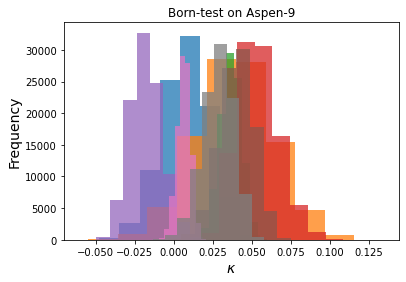

In [18]:
labels = ['1024(qvm)', '1024', '2048', '2048(qvm)', '4096', '4096', '8192']
for i in range(len(boot_res)):
    plt.hist(boot_res[i][0], alpha=0.75)
# plt.legend(loc='upper center')
plt.xlabel('$\\kappa$', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Born-test on Aspen-9')
plt.savefig('Born_test_on_Aspen.pdf', bbox_inches='tight')
plt.show()

In [19]:
filenames

['Born_2021_05_11_bits_10_11_1024_shots_10_runs_0_asqvm.pkl',
 'Born_2021_05_11_bits_10_11_1024_shots_10_runs_0.pkl',
 'Born_2021_05_11_bits_10_11_2048_shots_10_runs_0_asqvm.pkl',
 'Born_2021_05_11_bits_10_11_2048_shots_10_runs_0.pkl',
 'Born_2021_05_11_bits_10_11_4096_shots_10_runs_0_asqvm.pkl',
 'Born_2021_05_11_bits_10_11_4096_shots_10_runs_0.pkl',
 'Born_2021_05_11_bits_10_11_8192_shots_10_runs_0_asqvm.pkl',
 'Born_2021_05_11_bits_10_11_8192_shots_10_runs_0.pkl']